# ChIP AML PiPeline V2

In [40]:
import os
from IPython.display import IFrame
import pandas as pd
import sys
sys.path.insert(0, '../JKBio/')
import epigenetics.ChIP_helper as chiphelper
import Helper as helper
import igv
import numpy as np
import pyBigWig
import itertools
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from bokeh.plotting import *
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
output_notebook()
%load_ext autoreload
%autoreload 2

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## adding the data bucket to path

In [9]:
! gcsfuse --only-dir Chip_AML jkobject data/seqs

Using mount point: /home/jeremie/AMLproject/data/seqs
Opening GCS connection...
Opening bucket...
Mounting file system...
File system has been successfully mounted.


## doing nextflow analysis

In [2]:
singleend, pairedend = chiphelper.extractPairedSingleEndFrom('data/seqs')

## Pipeline

![](images/gcpjup.png)


- Raw read QC (FastQC)
- Adapter trimming (Trim Galore!)
- Alignment (BWA)
- Mark duplicates (picard)
- Merge alignments from multiple libraries of the same sample (picard)
- Re-mark duplicates (picard)
- Filtering to remove: blacklisted regions, duplicates, primary alignments,unmapped,multiple locations, containing >  4 mismatches, insert size > 2kb, map to different chromosomes 
- Alignment-level QC and estimation of library complexity (picard, Preseq)
- Create normalised bigWig files scaled to 1 million mapped reads (BEDTools, bedGraphToBigWig)
- Generate gene-body meta-profile from bigWig files (deepTools)
- Calculate genome-wide IP enrichment relative to control (deepTools)
- Calculate strand cross-correlation peak and ChIP-seq quality measures including NSC and RSC (phantompeakqualtools)
- Call broad/narrow peaks (MACS2)
- Annotate peaks relative to gene features (HOMER)
- Create consensus peakset across all samples and create tabular file to aid in the filtering of the data (BEDTools)
- Count reads in consensus peaks (featureCounts)

![](images/nfcore.png)


In [1]:
! nextflow cloud create 'JKcluster' -c 4

Unknow cloud driver name: google


In [ ]:
! nextflow cloud create jkcluster -c "nextflow/nextflow.config" 40 && \
nextflow nf-core/chipseq -c "nextflow/nextflow.config" \
--singleEnd \
--seq_center 'DFCI' \
--email 'jkobject@gmail.com' \
--bucket-dir 'gs://jkobject/Chip_AML/nextflow/CHIPprocess_2/' \
--keyfile '~/jkobject-b6f1adaffcb8.json' \
--projectname 'jkobject' \
--zone 'us-east1-b' \
--skipDiffAnalysis \
--narrowPeak \
--design "nextflow/design.csv" \ 
--genome 'GRCh38' \
--profile gcp \
--resume \
--skipPreseq \
--max_cpus 8 && \
nextflow cloud shutdown jkclustert

## displayingPeaks

In [ ]:
bindings = chiphelper.loadNarrowPeaks('data/seqs/results/bwa/narrowPeak/', isMacs=False,skiprows=1)

In [16]:
bindings.to_csv('temp/bindings.bed',sep='\t',index=False,header=False)

In [3]:
bindings= pd.read_csv('temp/bindings.bed',sep='\t',header=None, 
                      names=["chrom","start","end","peak_number","size","foldchange","-log10pvalue",
                             "-log10qvalue","relative_summit_pos","name"])

/home/jeremie/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
SEgenes = pd.read_csv('data/SEgenes.csv')
CTF = pd.read_csv('data/CTF.csv', header=None)[0].tolist()
CTF.extend(['GATA2','IKZF1','LYL1' ,'PU1','SMC1'])
CTF = list(set(CTF) - (set(CTF) - set([i.split('_')[0] for i in set(bindings.name.tolist())])))
CTF

['GFI1',
 'IRF8',
 'GATA2',
 'ZMYND8',
 'PU1',
 'IRF2BP2',
 'ETV6',
 'LYL1',
 'GSE1',
 'LMO2',
 'RUNX1',
 'ELF2',
 'SMC1',
 'IKZF1',
 'MEF2C',
 'CEBPA',
 'FLI1',
 'MYC',
 'SP1',
 'RUNX2',
 'ZEB2',
 'MYB',
 'MEIS1',
 'MEF2D']

In [31]:
bindings[bindings.name=='MYC_R1_peaks'].to_csv('temp/mycpeaks.bed',sep='\t',index=False,header=False)

In [5]:
bindings

,chrom,start,end,peak_number,size,foldchange,-log10pvalue,-log10qvalue,relative_summit_pos,name
0,1,10151,10661,SMC1_R1_peak_1,12213950,5.84939,21.35620,18.56608,323,SMC1_R1_peaks
1,1,237573,237944,SMC1_R1_peak_2,12213950,25.09560,89.74677,86.13345,180,SMC1_R1_peaks
2,1,240866,241173,PU1_R1_peak_1,12213950,4.62773,6.61859,4.54232,172,PU1_R1_peaks
3,1,240888,241096,MAX_R1_peak_1,12213950,4.64352,7.49377,5.41401,158,MAX_R1_peaks
4,1,521397,521761,SMC1_R1_peak_3,12213950,18.57726,59.50064,56.17862,185,SMC1_R1_peaks
...,...,...,...,...,...,...,...,...,...,...
1221390,Y,28461300,28461596,CTCF_R1_peak_36855,12213950,9.05243,15.02673,12.30668,140,CTCF_R1_peaks
1221391,Y,28709197,28709471,CTCF_R1_peak_36856,12213950,5.76064,8.45496,5.89134,111,CTCF_R1_peaks
1221392,Y,59002975,59003351,IGG_R1_peak_6,12213950,2.66065,9.67161,2.99059,194,IGG_R1_peaks
1221393,Y,59004665,59004905,CEBPA_R1_peak_24454,12213950,4.54848,16.17649,12.97859,110,CEBPA_R1_peaks


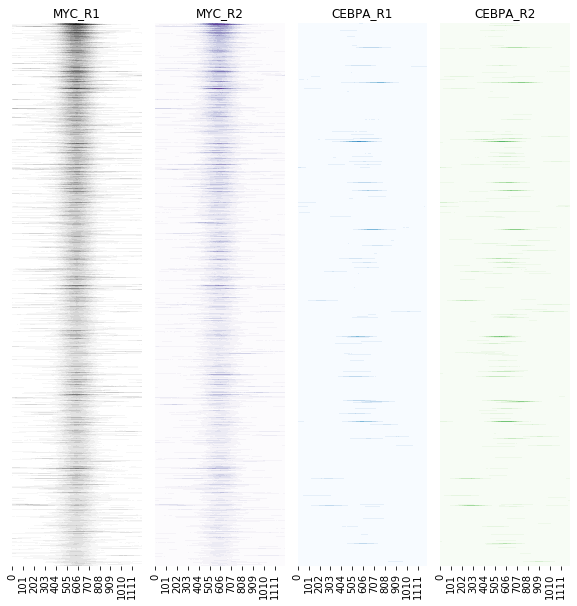

In [10]:
%matplotlib inline
peakstoplot, figure = chiphelper.computePeaksAt(
    bindings[bindings.name=='MYC_R1_peaks'],
    bigwigs=[
    "MYC_R1.mLb.clN.bigWig",
    "MYC_R2.mLb.clN.bigWig",
    "CEBPA_R1.mLb.clN.bigWig",
    "CEBPA_R2.mLb.clN.bigWig",
], folder='data/bigwig/', window=600,numpeaks=2000, width=10,length=10)

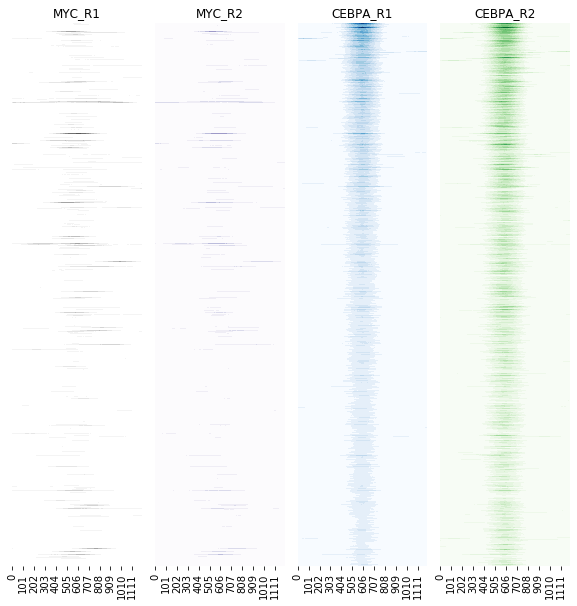

In [15]:
%matplotlib inline
peakstoplot, figure = chiphelper.computePeaksAt(
    bindings[bindings.name=='CEBPA_R1'],
    bigwigs=[
    "MYC_R1.mLb.clN.bigWig",
    "MYC_R2.mLb.clN.bigWig",
    "CEBPA_R1.mLb.clN.bigWig",
    "CEBPA_R2.mLb.clN.bigWig",
], folder='data/bigwig/', window=600,numpeaks=8000, width=10,length=10)

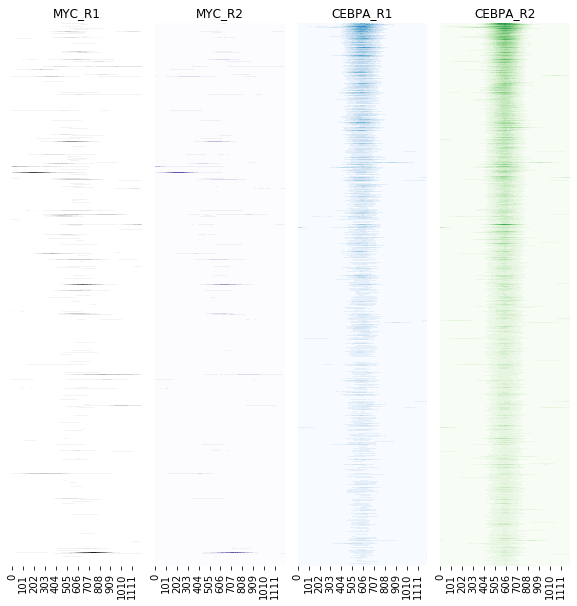

In [17]:
%matplotlib inline
peakstoplot, figure = chiphelper.computePeaksAt(
    bindings[bindings.name=='CEBPA_R2'],
    bigwigs=[
    "MYC_R1.mLb.clN.bigWig",
    "MYC_R2.mLb.clN.bigWig",
    "CEBPA_R1.mLb.clN.bigWig",
    "CEBPA_R2.mLb.clN.bigWig",
], folder='data/bigwig/', window=600,numpeaks=10000, width=10,length=10)

## Marking each TF with a different quality score

## merging duplicates

In [5]:
replicates = chiphelper.findReplicates(folder='data/seqs/results/bwa/', sep='_', namings='_R([0-9])',namepos=0)

# we do a visual inspection of the features and and look at QCs

### [igv tracks](https://igv.org/app/?sessionURL=blob:3Z3rU9rcFsb_lU6.vO.Zg0EIcvGbolinYB0vp5czHSeEGFIhscmOaJ3.790hwMbzsrZZ9rTJIx.YAfIk62HxY7Mfcnk0IvfajdzAcY3dR8MfGbvG2Kt1jIoR2FP5nPE2mdrBm7.7Z92x1aqmr_1Lvnhtx8K.POuniwtxG.9Wq7FljhJ7Ip93bswk3nLlIls1057a38PAnsWmE06rvndnDqPQHvlBLHyRCNcMI6_quUE4deNq7H6bb2J.Z843IjfmByP3_o9sTN77coPOgwiHdjD6jdtMN7EvN2GKe2H8qBiT0EliY_e_hj2ZGF8qhojkVtInHg3xcJs2QkqTeZ8qRhiN3MjYlRtvdVrNjlWzGu1m3arttNx_W9tt2bvw_NYPgnQhESXuj8qjkUQTuRIvNfL1Jhx.dR1R7Y7926u9Qb8auXEyEXF1OLOrUzfy3FHfH0Z29FAd.t7M96q9_nHt6qxmTvtD05mcmPLpD773pDdBMpmsSttefX5IpRNOQrmkEXnDv7cr25Vaq51.suyJ6G5.Zez63lgYu5ZcuZ2I8NyxJ3ILqcGKMZOFhLNeEjjCDwMpnrp2IEV3fuwP_YkvHj7Ml5CvbNXk85PQW.ivZUvlCv7nLZMfcX_iPuchDpPIcS.yBqWCFI0wmtqyTCN76.QziwZmD9LKY1U5qzWBHUXh7NS1b5YNubqVD2JTvUC3pLZqyV9T28mEf_1KH.pP.7B4H__RCCdMAqHpRI43fpNL7VufLZmq1NtvB0Eo7HlRFWNq35.FM8nXzrZ0IeXCjdJ1zRF0xlE4DWMJrFxSkusaX36doKMej6D6ql2kEogg0kNxBC1KYhBkARKkcYlG0PHJ6eUFB6HGql.0FIgh2sQfhmhjdwaHvfoBpzs7q.7QUqDu0CaK.4pb1sT4jmsCfsfpbKJ9yZ1esn4ltFbtooRACFEWigMoq4iBTzr3QsOHNokGz_kpC56amhJRSiB6KAvF0ZNVxJmiqkkPDj60SzR8Ph_u11n8qAkRKQUCiPRQHEGLkjgIqUkPDkIam2gMdQ_3T_dYEKl5EK0Foog2URxGy5o4HCFOhHQ.QUGq5wdJzYVoLR5IG0wUDlKdAxLilEjnEw6ki26PNSB1FEeUFAkjykOBFGUlMSBKP_J4ENE20Rg6GJy_v2qPr95a7.ot.f5z_sdTIUOetQCRlcdOcZD9szoOb4hBRD7HqOgN9j6ysFPZxHNrAESOslI8blllHNQQA4vn3UJi9pLhTcUXz64CDbQSD2wvG9UQM40cdtFYO.z3WDl7XSUbpBSILdJDcUwtSuKwhBhraGxiMpQ_HayrVIOUwjFUqmxwURJnf0rEVENjE46hi_80OeOQpaIMUorEEOWhQIaykjgMISYVGpuYDOUfhyyVS5BSOIbKNQ5lJXEYQowgNDYxGbLyM6QyB1IKx9AGD0UzZHEYQswWNDbhDi_bu9hjhQqWChVoLdIRZqSJAg8xW9TE4QgxV9D5BAWJ8YtOJQu0Fg.kUv2mW9bEAKmBGC7ofMKBdH7IOhqjodIFUoqEEeWhQIqykjgQIaYLGpuYDOUfixoqXSClcAyVayTKSuIwhJguaGyiMfSCnRoaKmB4JfszlHNXhhftxdBATBpe1w4Mx0dHLJxU1EApkU7DQVgoDqOsIg5CiCED7RIOn3efe7ypkYoYaC0SQqSJAiFa1MTAaAcxYtD5BAUp__xoR2UMtBYPpFLNkJY1cUBCjBl0PuFAOuvV909Z_x_tqKhBp0aCSWOjQJxWVXGAQswc9E5hkWKMTip20KkRkSrXCLWqioMUYuygdwqLVP5dhXbWogeNGhGpUu0wpKriIAUZQ2idwiLVyI_UWhihUSMitcFGCZBqcE7fChlJaJ0CItXmTKSaa5kEJcWCabOHQklKS.JgBBlI0DbRGOoP3rPCiKYKI0gpEEOkh.IYWpTEYQgxg9DYxGQof_rQVOkDKYVjqFS5w6IkDkOIoYPGJhxDn_qsP2qbKm4gpUgMUR4KZCgricMQYsqgsYnGEPPEXU0VL7yCE3aV70Rd7BN0tRAjhddzYq7B4QHvijAqTiClUJdVIjwUeVWleUkchBDjBI1NPIZ69S4LIpUn0Fqwi5NtNlHsxcnSmjgcIUYKOp.gIOUPFVpPr_K3WYsHUqlihWVNHJBQL_NH.QQFKf.ODC2VLNBaPJBKtRPDsiYOSIjhgs4nHkjH57z50Vq.QGqhQKJMFAlSVhPnwpmQKYPGJxxIn_Y5GLXXYgZCiQQRYaFAhOYVcQCCzBhIl5D45J8XtdcCBkKJhk.55kTzijj4QEYLpEs8fFj5XHstViCUUPiULpubV8TBBzJQIF1C4sMYfdbCBEKJhk_JRh9mHteGjBFIl2j4nL7vHx.zxh8VItBaIIRoE8VBtKyJgVEHMUTQ.UQD6ezy5CMrjeuoGIHWAoFEmygOpGVNHJAQwwSdT0SQWEdAdFSgQGvBQCrbMRDLmjggIcYKOp9oIJ0PurwBSSULpBQII9JDcRQtSuJAhBguaGyiMfT5cJ91JFFHxQukFIgh0kNxDC1K4jCEmDBobMIxNPh0csA6LryjMgaNGIkj2kWBJC2LYrBUSz80eDDpnKLilH9Qqm2rqEGjBuTpt41My.mAex27394cydbF6.uJ3Ot5OyuLXo6FuE3bGVvmKJHlC9u5MZN4y7VjsVUz7an9PQzsWWw64bTqe3dmGHmmXIP8ZMTVsVfryLZfp1sx4zAS7sgU98L0vj9p6e_aiCmG_sa.bMlPTeROwzt7uNYW9UWQ3vRtokxt6tH_Ba4vP34C)

### [multiQC](http://35.184.213.1:8888/view/data/results/multiqc/multiqc_report.html)

### process: 

look at all t with a very low frip score as noted by encode. 

look at all peaks tracks together and see for location of intense co binding. 

- if we can discern peaks and if, for some reasons, some good peaks are not called by macs. 
- if looks good and we can see a lot of peaks. 
- if a lot of noise but seems consistent with replicates. 
- if just seems to have very few peaks.

Validate still but flag as potentially bad.

Else remove.

### results:

In [12]:
toremove=['ETV6_R3'
'ELF2_R2'
'MEF2D_R1'
'RUNX2_R1'
'IKZF1_R2']

bad=[
"LMO2_R1",
"LMO2_R2",
"IRF2BP2_R2",
"IRF2BP2_R4",
"MEF2C_R1",
"MEF2C_R2",
"MEF2C_R3",
"MEF2D_R2",
"MEF2D_R3",
"ZMYND8_R2",
"GATA2_R1",
"GSE1_R1",
"GSE1_R2",
"ZEB2_R1",
"ZEB2_R1",
"GFI1_R1",
"POL2",
"IRF2BP2_R3"]

In [13]:
bindings['name']= [i[:-6] for i in bindings['name']]
bindings['tf'] = [i.split('_')[0] for i in bindings['name']]
bindings=bindings[~bindings.name.isin(toremove)]

In [9]:
bindings

,chrom,start,end,peak_number,size,foldchange,-log10pvalue,-log10qvalue,relative_summit_pos,name,tf
0,1,10151,10661,SMC1_R1_peak_1,12213950,5.84939,21.35620,18.56608,323,SMC1_R1,SMC1
1,1,237573,237944,SMC1_R1_peak_2,12213950,25.09560,89.74677,86.13345,180,SMC1_R1,SMC1
2,1,240866,241173,PU1_R1_peak_1,12213950,4.62773,6.61859,4.54232,172,PU1_R1,PU1
3,1,240888,241096,MAX_R1_peak_1,12213950,4.64352,7.49377,5.41401,158,MAX_R1,MAX
4,1,521397,521761,SMC1_R1_peak_3,12213950,18.57726,59.50064,56.17862,185,SMC1_R1,SMC1
...,...,...,...,...,...,...,...,...,...,...,...
1221390,Y,28461300,28461596,CTCF_R1_peak_36855,12213950,9.05243,15.02673,12.30668,140,CTCF_R1,CTCF
1221391,Y,28709197,28709471,CTCF_R1_peak_36856,12213950,5.76064,8.45496,5.89134,111,CTCF_R1,CTCF
1221392,Y,59002975,59003351,IGG_R1_peak_6,12213950,2.66065,9.67161,2.99059,194,IGG_R1,IGG
1221393,Y,59004665,59004905,CEBPA_R1_peak_24454,12213950,4.54848,16.17649,12.97859,110,CEBPA_R1,CEBPA


In [10]:
replicates

{'CEBPA': ['CEBPA_R1.mLb.clN.sorted.bam', 'CEBPA_R2.mLb.clN.sorted.bam'],
 'CTCF': ['CTCF_R1.mLb.clN.sorted.bam'],
 'DMSO': ['DMSO_8h_H3K27ac_R1.mLb.clN.sorted.bam',
  'DMSO_8h_MAX_R1.mLb.clN.sorted.bam',
  'DMSO_H3K27ac_R1.mLb.clN.sorted.bam'],
 'ELF2': ['ELF2_R1.mLb.clN.sorted.bam', 'ELF2_R2.mLb.clN.sorted.bam'],
 'ETV6': ['ETV6_R1.mLb.clN.sorted.bam',
  'ETV6_R2.mLb.clN.sorted.bam',
  'ETV6_R3.mLb.clN.sorted.bam'],
 'FLI1': ['FLI1_R1.mLb.clN.sorted.bam'],
 'GATA2': ['GATA2_R1.mLb.clN.sorted.bam', 'GATA2_R2.mLb.clN.sorted.bam'],
 'GFI1': ['GFI1_R1.mLb.clN.sorted.bam'],
 'GSE1': ['GSE1_R1.mLb.clN.sorted.bam', 'GSE1_R2.mLb.clN.sorted.bam'],
 'H3K27ac': ['H3K27ac_R1.mLb.clN.sorted.bam'],
 'IGG': ['IGG_R1.mLb.clN.sorted.bam'],
 'IKZF1': ['IKZF1_R1.mLb.clN.sorted.bam', 'IKZF1_R2.mLb.clN.sorted.bam'],
 'INPUT': ['INPUT_R1.mLb.clN.sorted.bam'],
 'IRF2BP2': ['IRF2BP2_R1.mLb.clN.sorted.bam',
  'IRF2BP2_R2.mLb.clN.sorted.bam',
  'IRF2BP2_R3.mLb.clN.sorted.bam',
  'IRF2BP2_R4.mLb.clN.sorted.bam

### Merge

**If A U B  > ½ A and #A = #B** *we merge peaks and flag for bam merge

**If 0 < A U B  < ½ A and #A >> #B**  *we keep only A and flag for bam merge

- Not so good of an overlap. 
- Most of the time, one will have much more peak than the other

all is about choosing values of:
- how much is enough overlap, 
- how much read is enough to say we found an uncalled peak...


/!/ should only be passed peaks with at least one good replicate
merging 2 CEBPA peaks
finish first overlaps lookup               
we only have one replicate for CTCF .. pass
merging 3 DMSO peaks
finish first overlaps lookup                   
Wrong TF
merging 2 ELF2 peaks
finish first overlaps lookup          
merging 3 ETV6 peaks
finish first overlaps lookup
Wrong TF
we only have one replicate for FLI1 .. pass
merging 2 GATA2 peaks
finish first overlaps lookup
we only have one replicate for GFI1 .. pass
merging 2 GSE1 peaks
finish first overlaps lookup
!TF has less than 1000 PEAKS!
Wrong TF
we only have one replicate for H3K27ac .. pass
we only have one replicate for IGG .. pass
merging 2 IKZF1 peaks
finish first overlaps lookup
we only have one replicate for INPUT .. pass
merging 4 IRF2BP2 peaks
finish first overlaps lookup
we only have one replicate for IRF8 .. pass
merging 2 LMO2 peaks
finish first overlaps lookup
we only have one replicate for LYL1 .. pass
we only have one replic

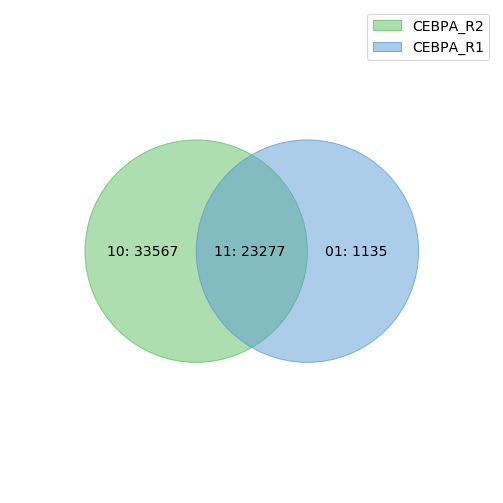

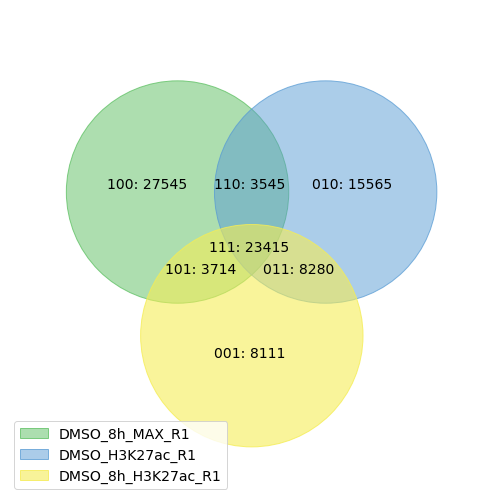

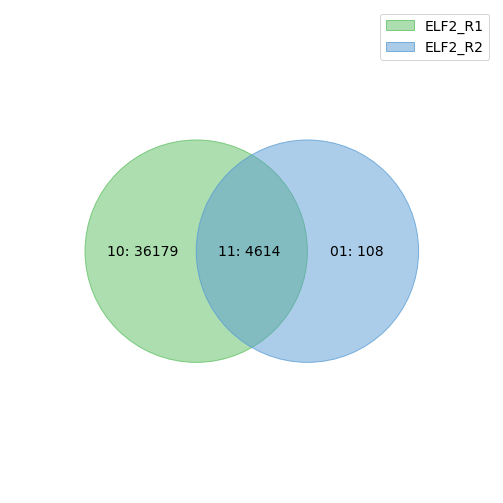

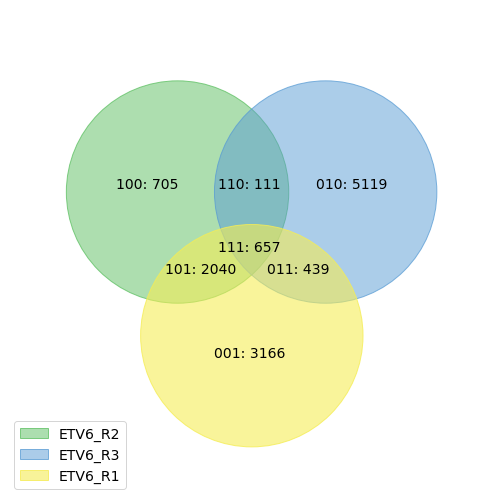

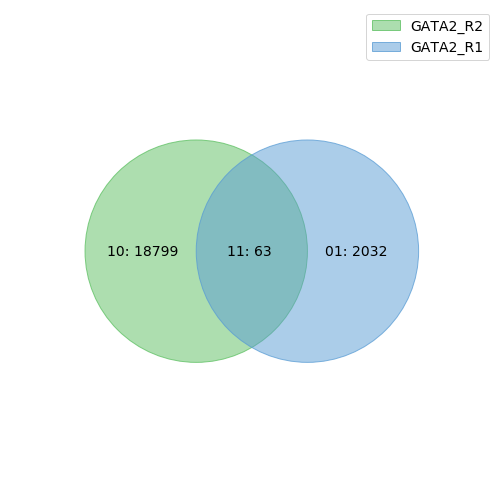

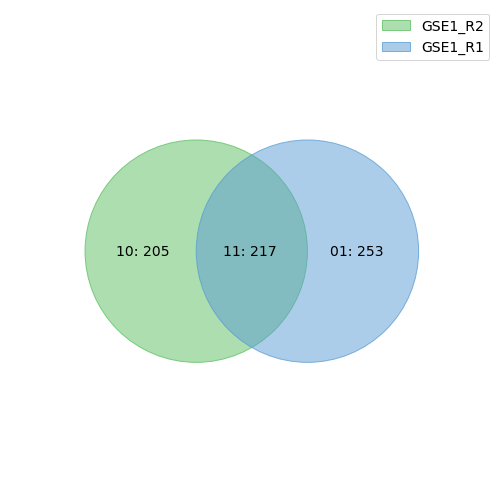

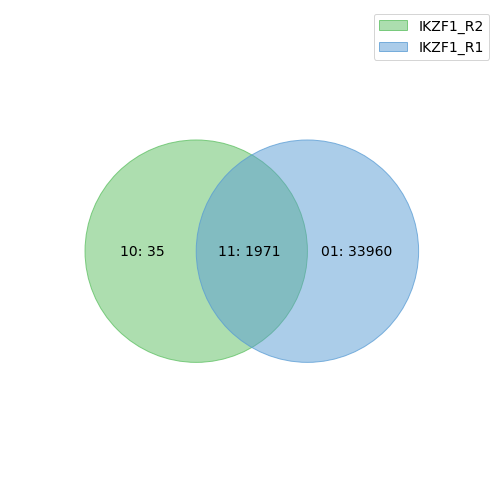

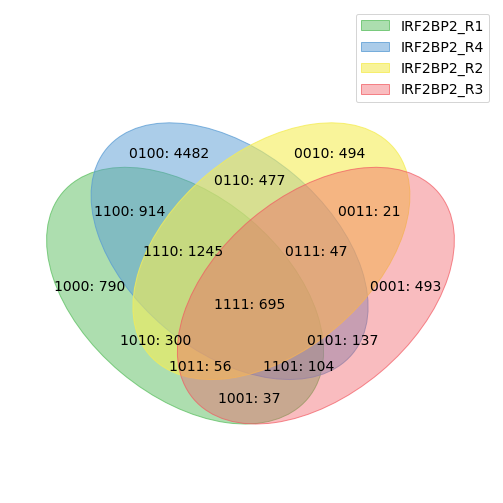

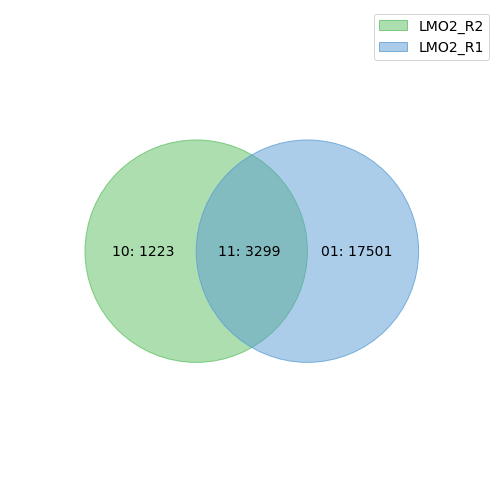

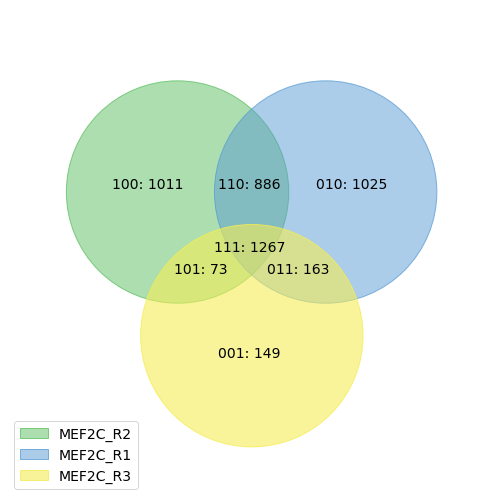

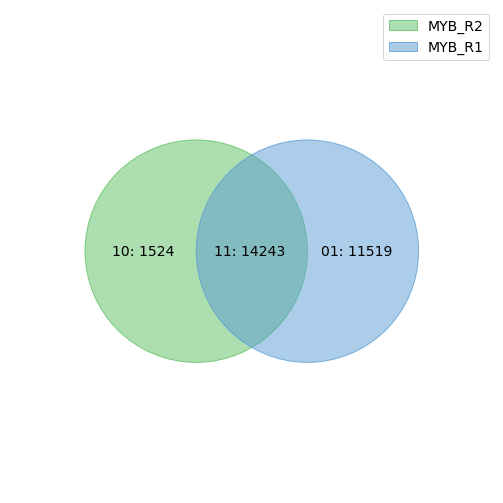

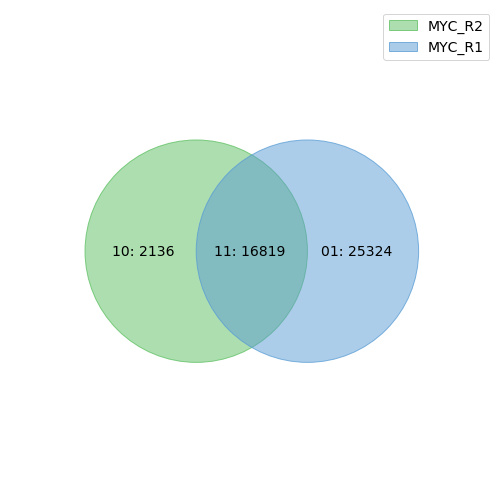

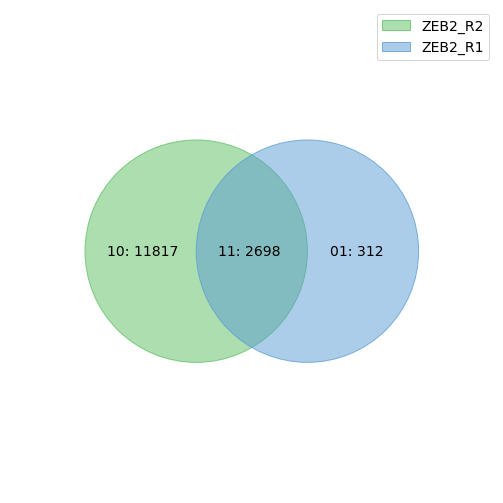

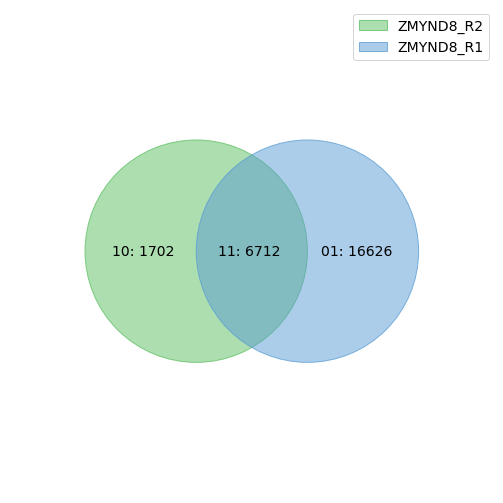

In [284]:
%matplotlib inline
mergedpeak, tomergebam, remove = chiphelper.mergeReplicatePeaks(bindings,
                            replicates,'data/bigwig/',markedasbad=bad,
                            window=200, mincov=4, doPlot=True, cov={}, use='max',
                            MINOVERLAP=0.5, SIZECUTOFF=0.7, mergewindow=50)

In [ ]:
ELF2
GATA2
IKZF1
ZEB2

In [14]:
tomergebam = [['CEBPA_R2', 'CEBPA_R1'],
 ['IRF2BP2_R4', 'IRF2BP2_R1'],
 ['IRF2BP2_R4', 'IRF2BP2_R2'],
 ['IRF2BP2_R4', 'IRF2BP2_R3'],
 ['LMO2_R1', 'LMO2_R2'],
 ['MEF2C_R1', 'MEF2C_R2'],
 ['MEF2C_R1', 'MEF2C_R3'],
 ['MYB_R1', 'MYB_R2'],
 ['MYC_R1', 'MYC_R2'],
 ['ZMYND8_R1', 'ZMYND8_R2']]

In [11]:
remove = ['DMSO','CTCF','ETV6','GSE1']

In [ ]:
mergedpeak = pd.concat([peaks for _, peaks in mergedpeak.items()]).drop(['tf','size'],1)

In [288]:
mergedpeak.drop(['tf','size'],1).to_csv('temp/merged.csv')

In [ ]:
mergedpeak.name = [i.split('_')[0] for i in mergedpeak.name]

## show replicates overlap

### sorting and removing samples

In [85]:
bigwigs=os.listdir('data/bigwig/')
for val in bigwigs:
    for v in remove + toremove + ['scale','POLII','IGG','CTCF','INPUT']:
        if v in val:
            bigwigs.remove(val)
            break
bigwigs = ['data/bigwig/'+ i for i in bigwigs]

In [19]:
merged = chiphelper.simpleMergedPeaks(mergedpeak[~mergedpeak.name.isin(
    toremove+remove+['scale','POLII','IGG','CTCF','INPUT'])], window=200)

NameError: name 'mergedpeak' is not defined

In [326]:
merged.to_csv('temp/merged.csv')

In [9]:
merged = pd.read_csv('temp/merged.csv').drop('Unnamed: 0',1)

/home/jeremie/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
bigwigs

['data/bigwig/ZEB2_R1.mLb.clN.bigWig',
 'data/bigwig/SMC1_R1.mLb.clN.bigWig',
 'data/bigwig/ZMYND8_R1.mLb.clN.bigWig',
 'data/bigwig/ELF2_R1.mLb.clN.bigWig',
 'data/bigwig/GFI1_R1.mLb.clN.bigWig',
 'data/bigwig/MEF2C_R1.mLb.clN.bigWig',
 'data/bigwig/FLI1_R1.mLb.clN.bigWig',
 'data/bigwig/IRF2BP2_R2.mLb.clN.bigWig',
 'data/bigwig/IRF2BP2_R1.mLb.clN.bigWig',
 'data/bigwig/MED1_R1.mLb.clN.bigWig',
 'data/bigwig/IRF2BP2_R3.mLb.clN.bigWig',
 'data/bigwig/MEF2C_R3.mLb.clN.bigWig',
 'data/bigwig/CEBPA_R1.mLb.clN.bigWig',
 'data/bigwig/GATA2_R1.mLb.clN.bigWig',
 'data/bigwig/PU1_R1.mLb.clN.bigWig',
 'data/bigwig/SP1_R1.mLb.clN.bigWig',
 'data/bigwig/IRF2BP2_R4.mLb.clN.bigWig',
 'data/bigwig/MYB_R2.mLb.clN.bigWig',
 'data/bigwig/LMO2_R1.mLb.clN.bigWig',
 'data/bigwig/MYC_R2.mLb.clN.bigWig',
 'data/bigwig/GATA2_R2.mLb.clN.bigWig',
 'data/bigwig/ZMYND8_R2.mLb.clN.bigWig',
 'data/bigwig/LYL1_R1.mLb.clN.bigWig',
 'data/bigwig/ZEB2_R2.mLb.clN.bigWig',
 'data/bigwig/IRF8_R1.mLb.clN.bigWig',
 'data/b

## Co Binding Matrix

Look at AUC for all ChIPs over all peaks of all ChIPs

In [69]:
merged[merged.columns[8:]].sum(0)

ZEB2        13764
ZMYND8      21705
IKZF1       31983
MAX         70194
MED1        22843
ELF2        36014
LMO2        15689
PU1        103359
LYL1        11464
RUNX1       37430
MEIS1       58341
IRF2BP2      7585
H3K27ac     45028
MEF2D         201
MYC         37550
MEF2C        3578
RUNX2         957
SP1         10799
GFI1         7107
GATA2       18631
SMC1        60484
IRF8        61937
MYB         19962
CEBPA       54514
FLI1        53710
dtype: int64

In [73]:
i = merged[merged.columns[8:]].sum(1)
i.max(),i.mean(),i.min()

(24, 3.45236440692507, 1)

In [23]:
cor = chiphelper.createCorrMatrix(merged, bigwigs, window=10)

hello
doing file data/bigwig/ZEB2_R1.mLb.clN.bigWig
doing file data/bigwig/SMC1_R1.mLb.clN.bigWig
doing file data/bigwig/ZMYND8_R1.mLb.clN.bigWig
doing file data/bigwig/ELF2_R1.mLb.clN.bigWig
doing file data/bigwig/GFI1_R1.mLb.clN.bigWig
doing file data/bigwig/MEF2C_R1.mLb.clN.bigWig
doing file data/bigwig/FLI1_R1.mLb.clN.bigWig
doing file data/bigwig/IRF2BP2_R2.mLb.clN.bigWig
doing file data/bigwig/IRF2BP2_R1.mLb.clN.bigWig
doing file data/bigwig/MED1_R1.mLb.clN.bigWig
doing file data/bigwig/IRF2BP2_R3.mLb.clN.bigWig
doing file data/bigwig/MEF2C_R3.mLb.clN.bigWig
doing file data/bigwig/CEBPA_R1.mLb.clN.bigWig
doing file data/bigwig/GATA2_R1.mLb.clN.bigWig
doing file data/bigwig/PU1_R1.mLb.clN.bigWig
doing file data/bigwig/SP1_R1.mLb.clN.bigWig
doing file data/bigwig/IRF2BP2_R4.mLb.clN.bigWig
doing file data/bigwig/MYB_R2.mLb.clN.bigWig
doing file data/bigwig/LMO2_R1.mLb.clN.bigWig
doing file data/bigwig/MYC_R2.mLb.clN.bigWig
doing file data/bigwig/GATA2_R2.mLb.clN.bigWig
doing file da

In [30]:
np.save('temp/corr.npy', cor)

In [86]:
cor = np.load('temp/corr.npy')

In [87]:
cor.mean(0).min()

0.001601492756476727

In [88]:
cor.shape

(40, 233124)

## dropping weird samples: IKZF1_R1, GATA2_R2, IRF2BP2_R4

In [89]:
weird = [29,20,16]
cor  = np.delete(cor, weird, 0)
bigwigs = [a for i,a in enumerate(bigwigs) if i not in weird]

In [91]:
PCS=30
TOTVAR=50000

In [92]:
cor = np.log2(1+cor)
a = cor.var(0).argsort()
subcor = cor[:,a[-TOTVAR:]]

In [93]:
subcor.shape

(37, 50000)

In [94]:
subcor = PCA(PCS).fit_transform(subcor)

Text(0.5, 1, 'PCs of each binding profile over conscensus peakset')

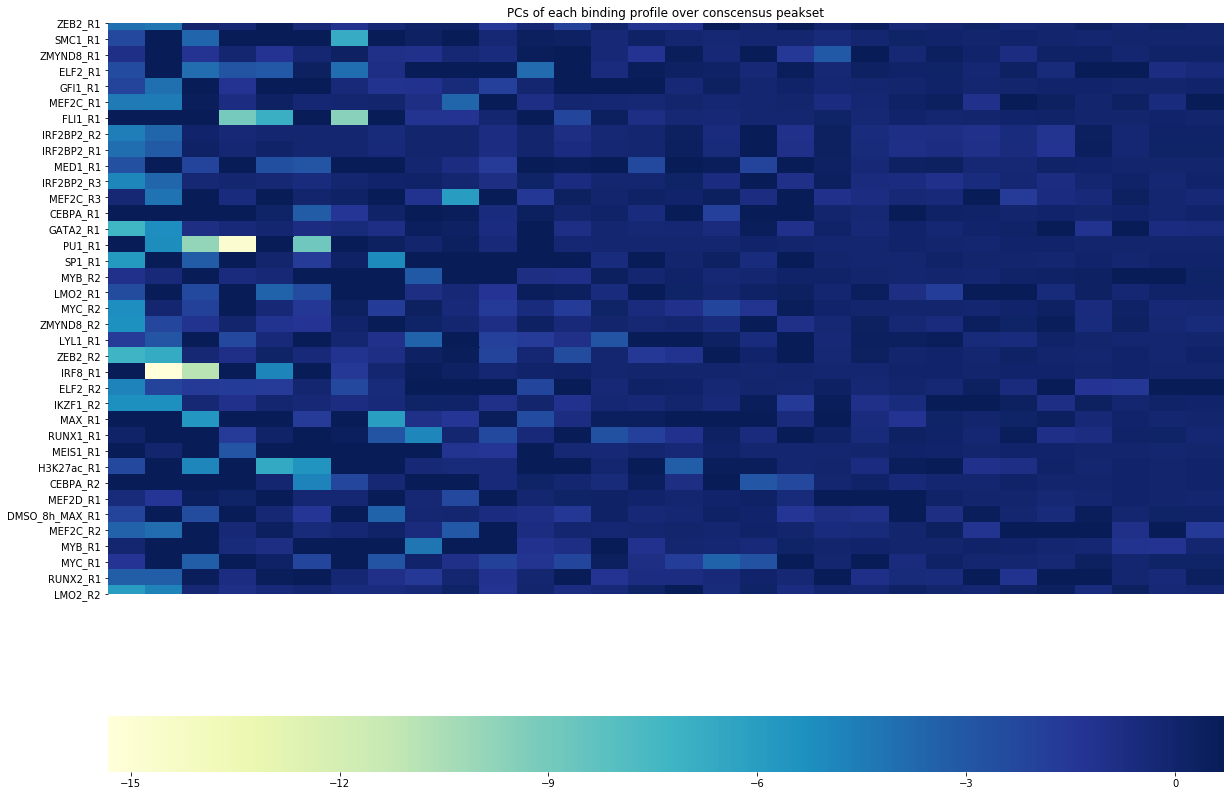

In [95]:
%matplotlib inline
cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
         'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
         'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
import seaborn as sns
from matplotlib import pyplot 
fig, ax = pyplot.subplots(figsize=(20,15))
sns.heatmap(ax=ax, data=subcor,xticklabels=False, cmap=cmaps[-4],
            yticklabels=[i.split('.')[-4].split('/')[-1] for i in bigwigs],
            cbar_kws={"orientation": "horizontal"},
            vmax=0.7).set_title('PCs of each binding profile over conscensus peakset')
#fig.savefig("temp/co_occupancy_matrix.png")

In [96]:
fig.savefig('PCs_binding_peakset.png')

In [97]:
model = AgglomerativeClustering(n_clusters=5,linkage="average", 
                                affinity="cosine", compute_full_tree=True)
labels = model.fit_predict(subcor)
ii = itertools.count(cor.shape[0])
tree = [{'node_id': next(ii), 'left': x[0], 'right':x[1]} for x in model.children_]

In [98]:
labels

array([3, 4, 2, 3, 3, 3, 0, 3, 3, 2, 3, 3, 0, 3, 0, 3, 1, 2, 3, 3, 1, 3,
       0, 3, 3, 2, 1, 0, 2, 0, 3, 2, 3, 1, 2, 3, 3])

## clustering

I have tried gaussian mixtures and Agglomerative clustering algorithm. Only the second can create a hierarchical clustering.

It seems that gaussian mixture makes more sense given the data we have, for now, is more "homogeneous". 

**I am still not so happy with the clustering.** It can be because of the how much importance, outlier values and the high number of noisy values from locations with no peaks.

We can use similar methods to RNAseq to improve this (clamping values, log transform, first round of PCA..)


In [68]:
labels = GaussianMixture(n_components=2, covariance_type='diag').fit_predict(subcor)

In [99]:
names = np.array([i.split('.')[-4].split('/')[-1] for i in bigwigs])
sort = labels.argsort()
p = helper.plotCorrelationMatrix(data=cor[sort],
                            names=names[sort],
                            colors=labels[sort],
                            title="correlation between TF occupancy",
                            interactive=True)

/home/jeremie/miniconda3/lib/python3.7/site-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/home/jeremie/miniconda3/lib/python3.7/site-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


In [101]:
show(p)

In [36]:
p = helper.scatter(TSNE(2,5).fit_transform(subcor),labels=names, colors=labels)

NameError: name 'names' is not defined

In [123]:
show(p)

# Next steps

## annotatePeaks

### based on closest expressed gene

### based on the ABC model

![](images/ABCtitle.png)

They tested a new model based on and validated by CRISPRi-FlowFISH which is basically able to find enhancer mapping to genes. 
They used it to compute their model's Accuracy and found a 70% accuracy compared to less than 50% for closest expressed gene. 

Way to integrate our HiC data (need ATAC-seq like data as well, but openly available) 


![](images/ABCmodel.png)

In [ ]:
Helper.scatter(TSNE(2,5).fit_transform(data.T), labels=zones.columns[11:],colors=labels)

## Compute the CRC and merge with gene assignement

~1500 lines of code. Seems to be a slightly updated version from the code I used the first time which was from their originial CRC paper. 

There is not a lot of documentation but it was just updated last week and might continue like that

![](images/CRCpres.png)

## find set of TFs that explain the most cobindings 

## relate to gene depencies

## what else?

### Compare data with other labs (H3K27, HiC..)

we need to redo everything for similar normal cell type, getting TFs based on the CRC (find it with CRCmapper or on litterature)

### Compare overlaps of flag ChIPs vs regular ChIPs